In [23]:

import pandas as pd
import numpy as np

from sklearn.model_selection import GroupKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, f1_score, recall_score, precision_score, confusion_matrix
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier


OUTCOME
False    5917
True     4083
Name: count, dtype: int64
Cross validation results:
accuracy: 0.7947000000000001
roc_auc: 0.8616027820451603
f1_score: 0.7433555103035456
sensitivity: 0.7285309380621354
specificity: 0.8403226912571661
ppv: 0.7589275288842845
npv: 0.8173923405078343


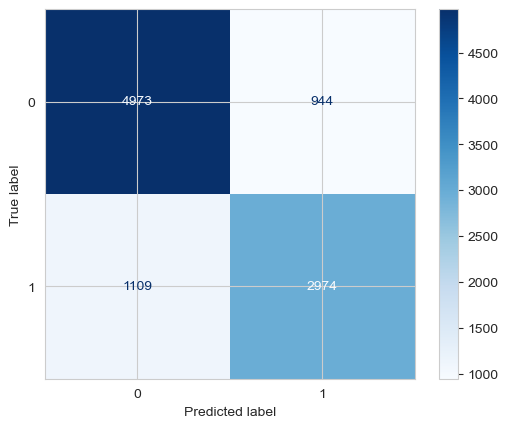

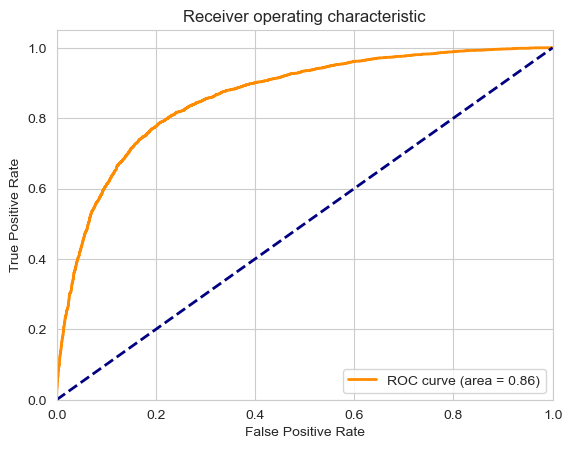

In [24]:

# Carga de datos
df = pd.read_csv('LABS/dataset_final_mejor.csv', delimiter=',', header=0, encoding='utf8')
df_nan = pd.read_csv('LABS/df_nan_mejor.csv', delimiter=',', header=0, encoding='utf8')

outcome = 'OUTCOME'

GFR = 30
num_admisiones = 10000
# nos quedamos con las num_admisiones con menos nan 
#merge de df_nan con df solo de GFR
df_nan = df_nan.merge(df[['hadm_id','GFR']], on='hadm_id', how='left')
df_nan = df_nan[df_nan['GFR'] > GFR]
df_nan = df_nan.sort_values(by=['nan'], ascending=True)
df_nan = df_nan.head(num_admisiones)
df = df[df['hadm_id'].isin(df_nan['hadm_id'])]

#guardamos df
df.to_csv('LABS/dataset_final_GPT.csv', index=False)


df = df.drop(columns=['hadm_id'])

df = df[df['GFR'] > GFR]

# Detectar automáticamente las variables categóricas
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Convertir variables detectadas a tipo 'categoría'
for col in categorical_features:
    if df[col].nunique() > 2:  # Más de dos categorías
        df[col] = df[col].astype('category')
    elif df[col].nunique() == 2:  # Exactamente dos categorías
        df[col], _ = pd.factorize(df[col])

# Ahora actualizamos la lista excluyendo 'subject_id' y las características con solo dos categorías.
categorical_features = [col for col in categorical_features if col != 'subject_id' and df[col].nunique() > 2]

# Finalmente, creamos variables dummy para aquellas características que han sido convertidas a 'categoría'.
df = pd.get_dummies(df, columns=categorical_features)

# Balance de los datos
print(df[outcome].value_counts())

# Definición de las métricas de evaluación
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def negative_predictive_value(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fn)

# Creación de diccionario de métricas de evaluación
scoring = {'accuracy': make_scorer(accuracy_score),
           'roc_auc': 'roc_auc',
           'f1_score': make_scorer(f1_score),
           'sensitivity': make_scorer(recall_score),
           'specificity': make_scorer(specificity_score),
           'ppv': make_scorer(precision_score),
           'npv': make_scorer(negative_predictive_value)}

# Definición del clasificador LGBM
clf = LGBMClassifier(verbose=-1, random_state=42)

# Preparar los datos
X = df.drop(columns=[outcome])  # Todas las columnas excepto la de resultado
y = df[outcome]  # La columna de resultado
groups = df['subject_id']  # Los grupos para GroupKFold

# Definición del GroupKFold
gkf = GroupKFold(n_splits=5)

'''
# Creación de la instancia RFECV con validación cruzada y usando AUC como métrica
selector = RFECV(estimator=clf, step=1, cv=GroupKFold(n_splits=5), scoring='roc_auc')

# Ajustar el RFECV al conjunto de datos
selector = selector.fit(X, y, groups=df['subject_id'])  # Asegúrate de pasar los grupos aquí

# Transformar el conjunto de datos a las características seleccionadas
X_selected = selector.transform(X)

# Mostrar las características seleccionadas
print("Características seleccionadas:")
print(X.columns[selector.support_])
'''

# Evaluación cruzada con GroupKFold
cv_results = cross_validate(clf, X, y, groups=groups, cv=gkf, scoring=scoring)

# Resultados de la validación cruzada
print("Cross validation results:")
for metric in scoring.keys():
    print(f"{metric}: {np.mean(cv_results['test_' + metric])}")
    
y_pred = cross_val_predict(clf, X, y, groups=groups, cv=gkf)

# Generar la matriz de confusión
cm = confusion_matrix(y, y_pred)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Plot AUC curve
import matplotlib.pyplot as plt

# Calculate probabilities of positive class
y_prob = cross_val_predict(clf, X, y, groups=groups, cv=gkf, method='predict_proba')[:, 1]

# Calculate fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(y, y_prob)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()



C:\Users\Oscar\.conda\envs\MIMIC\lib\site-packages\shap\explainers\_tree.py:386: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



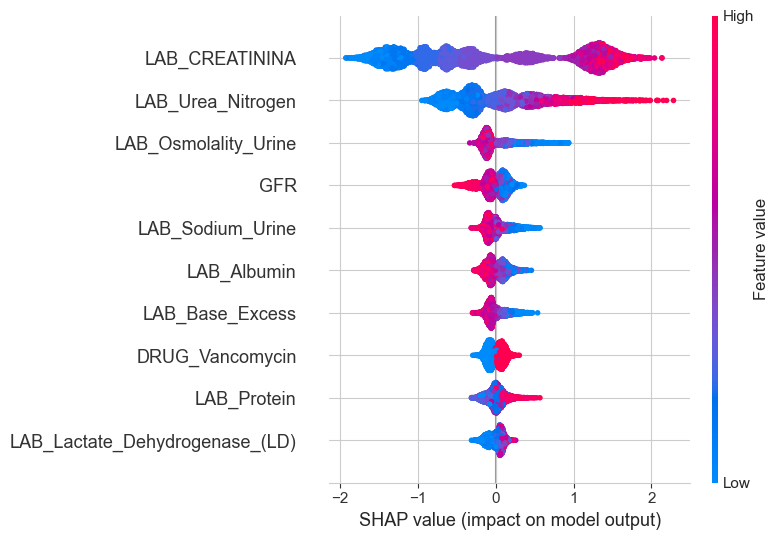

In [25]:
import shap

# Entrenar el modelo con todo el conjunto de datos
# Es importante recordar que para un análisis más profundo y realista se debe hacer
# este proceso dentro de un ciclo de validación cruzada, aquí se hace con el conjunto
# completo para ilustrar cómo calcular y mostrar las importancias SHAP.

clf.fit(X, y)

# Calculamos los valores SHAP
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

# Generar y mostrar el summary plot
shap.summary_plot(shap_values[1], X, plot_type="dot", max_display=10)


<Figure size 640x480 with 0 Axes>

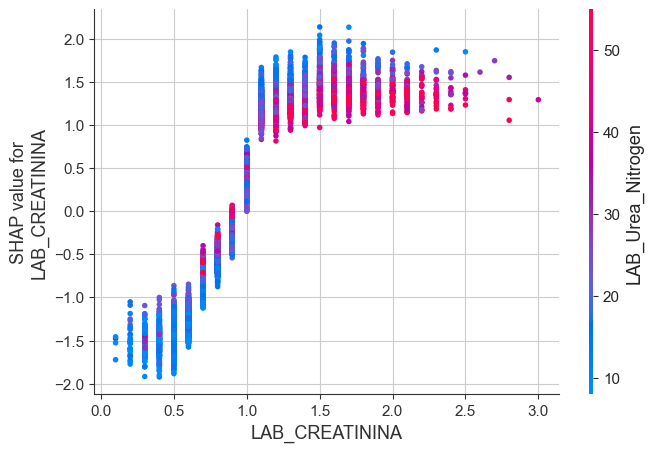

<Figure size 640x480 with 0 Axes>

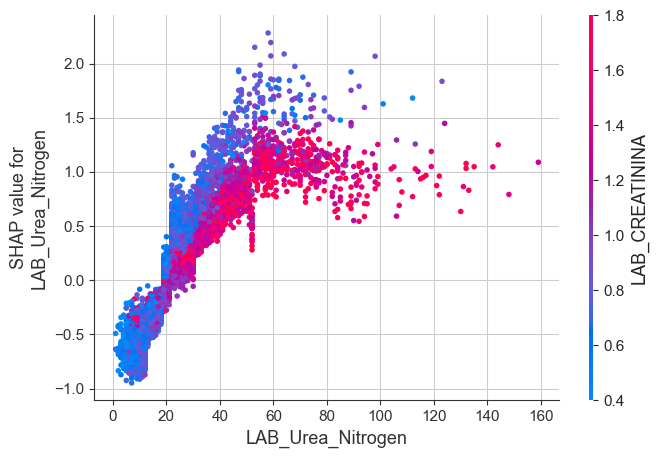

<Figure size 640x480 with 0 Axes>

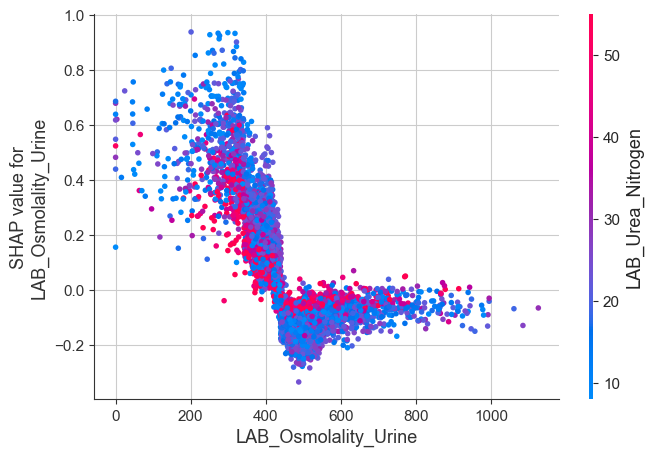

<Figure size 640x480 with 0 Axes>

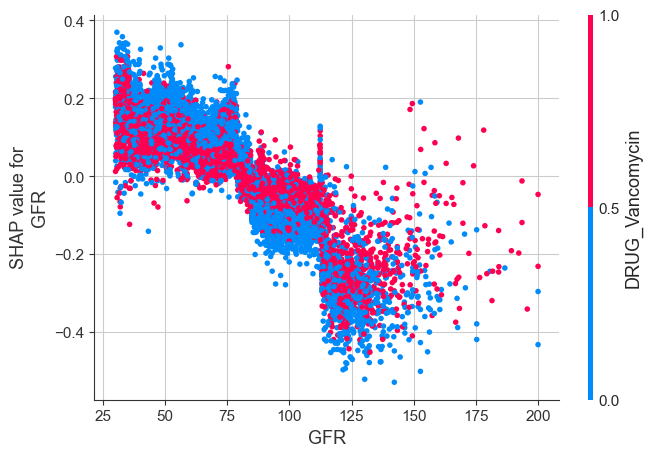

<Figure size 640x480 with 0 Axes>

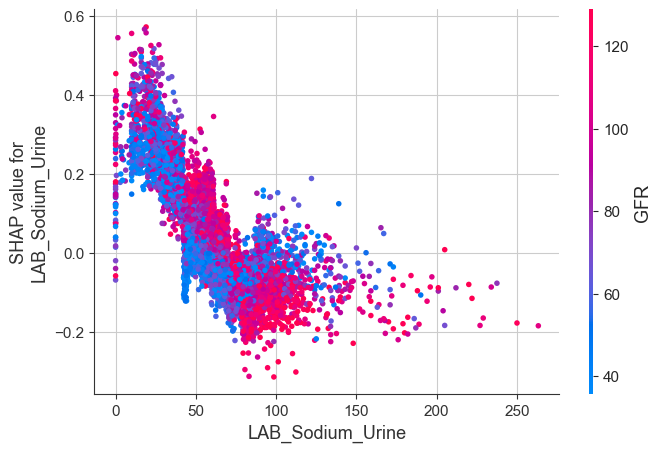

In [26]:
# Primero, promediamos los valores SHAP absolutos en todas las clases si es multiclase
shap_values_mean = np.abs(shap_values).mean(axis=0)

# Luego, sumamos esos valores para cada característica
summed_shap_values = np.sum(shap_values_mean, axis=0)

# Obtenemos los nombres de las características
feature_names = X.columns

# Creamos una serie en pandas para poder ordenar las características por importancia
importance = pd.Series(summed_shap_values, index=feature_names).sort_values(ascending=False)

# Seleccionamos las 5 características más importantes
top_features = importance.head(5).index

# Ahora, creamos un gráfico de dependencia para cada una de las cinco principales características
for feature in top_features:
    plt.figure()
    shap.dependence_plot(feature, shap_values[1], X, interaction_index='auto')
    plt.show()


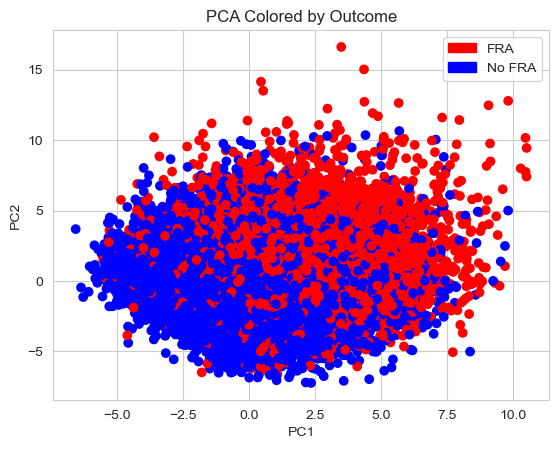

In [27]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
# Import necessary libraries


# Load the dataset
df = pd.read_csv('LABS/dataset_final_mejor.csv', delimiter=',', header=0, encoding='utf8')

outcome = 'OUTCOME'

df_copy = df.copy()
df = df_copy.select_dtypes(include=np.number)
df[outcome] = df_copy[outcome]

# Standardize the data
X = StandardScaler().fit_transform(df.drop(columns=[outcome]))

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

# Create a new dataframe with the principal components and outcome variable
df_pca = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])
df_pca[outcome] = df[outcome]

# Create a scatter plot of the first two principal components, colored by outcome
fig, ax = plt.subplots()
colors = {'False':'blue', 'True':'red'}
ax.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca[outcome].apply(lambda x: colors[str(x)]))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA Colored by Outcome')
#añadismo leyenda
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='FRA')
blue_patch = mpatches.Patch(color='blue', label='No FRA')
plt.legend(handles=[red_patch, blue_patch])
plt.show()






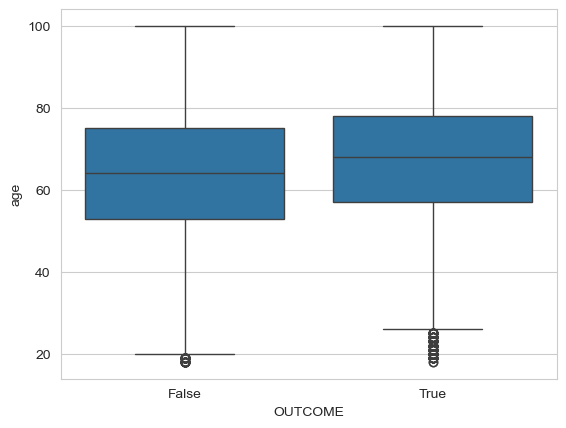

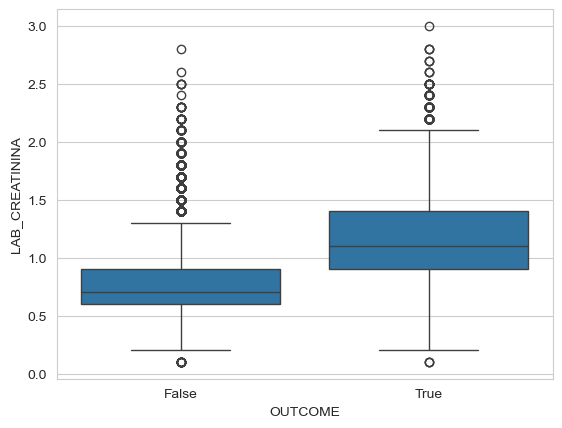

<AxesSubplot:xlabel='DRUG_Vancomycin', ylabel='count'>

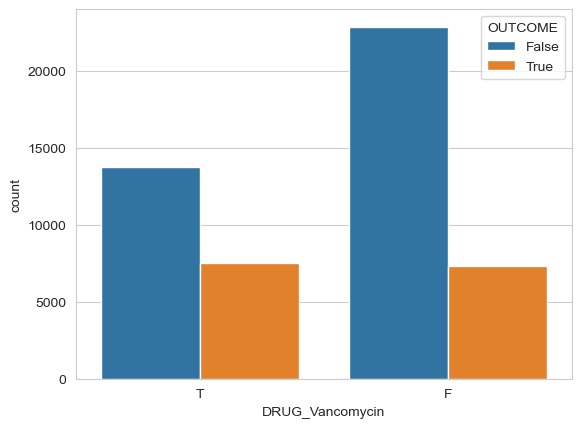

In [28]:
df = pd.read_csv('LABS/dataset_final_mejor.csv', delimiter=',', header=0, encoding='utf8')

# grafico boxplots de la edad en funcion del outcome
import seaborn as sns
sns.boxplot(x='OUTCOME', y='age', data=df)
plt.show()
# lo mismo con la creatinina
sns.boxplot(x='OUTCOME', y='LAB_CREATININA', data=df)
plt.show()
#ahroa plot que relacione las dos variables categoricas DRUG_Vancomycin y OUTCOME las dos estan en df
sns.countplot(x='DRUG_Vancomycin', hue='OUTCOME', data=df)



In [29]:
# Continuación de tu código anterior
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Realizamos PCA con 3 componentes
pca_3d = PCA(n_components=3)
principal_components_3d = pca_3d.fit_transform(X)


import plotly.express as px

# Utilizamos los datos del DataFrame que contiene los tres componentes principales
df_pca_3d = pd.DataFrame(data=principal_components_3d, columns=['PC1', 'PC2', 'PC3'])
df_pca_3d[outcome] = df[outcome]

# Crear el gráfico 3D interactivo con Plotly
fig = px.scatter_3d(df_pca_3d, x='PC1', y='PC2', z='PC3', color=outcome)

fig.update_traces(marker=dict(size=3))  # Puedes cambiar el número 3 por el tamaño deseado


# Configuraciones adicionales para el gráfico
fig.update_layout(
    title='3D PCA Colored by Outcome',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    )
)

# Mostrar el gráfico
fig.show()

plt.show()